In [1]:
import re
import os
import keras
import numpy as np
import pandas as pd

from PIL import Image

from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import combinations

%matplotlib inline

Using TensorFlow backend.


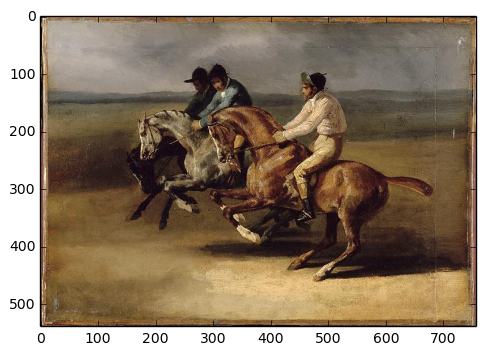

In [2]:
plt.imshow(plt.imread('/datasets/kaggle/painters/train/8.jpg'))

In [3]:
np.random.seed(seed=100500)

In [4]:
SAMPLES_FILE = 'out/samples-2m'
SAMPLES_SHAPE = (2000000,4102)
TEST_SIZE = .05
MODEL_PATH = 'out/same-artist-2b'

In [5]:
# read samples
samples = np.memmap(SAMPLES_FILE, dtype=np.float32, mode='r+', shape=SAMPLES_SHAPE)

In [6]:
# col1 - ys
y = samples.T[2:4].T
# col2,3 - fid pairs
pairs = samples.T[:2].T
# col4+ - features
X = samples.T[4:].T

In [7]:
# split data onto training/test sets
ntest = int(len(y) * TEST_SIZE)
y_train, y_test = (y[:-ntest], y[-ntest:])
X_train, X_test = (X[:-ntest], X[-ntest:])
pairs_train, pairs_test = (pairs[:-ntest], pairs[-ntest:])

In [8]:
X_train.shape[1]
y_train.shape[1]

2

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D
from keras.regularizers import l2, activity_l2

model = Sequential([
    Dense(1024, input_dim=X_train.shape[1], activation='relu', \
          W_regularizer=l2(0.001), b_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(512, activation='relu', \
          W_regularizer=l2(0.001), b_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', \
          W_regularizer=l2(0.001), b_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='SGD')

In [15]:
scores = []

In [ ]:
hist = model.fit(
        X_train,
        y_train,
        batch_size=100,
        nb_epoch=100, 
        validation_data=(X_test, y_test),
        callbacks = [
            MyCallback(max(scores) if len(scores) else 0)
        ]
     )

Train on 1900000 samples, validate on 100000 samples


51.098 % top-1

Saving to:  out/same-artist-2b@51.098.h5 

Epoch 1/100
1899900/1900000 [============================>.] - ETA: 0s - loss: 2.4664

74.892 % top-1

Saving to:  out/same-artist-2b@74.892.h5 

1900000/1900000 [==============================] - 1066s - loss: 2.4664 - val_loss: 0.5045
Epoch 2/100
1899900/1900000 [============================>.] - ETA: 0s - loss: 1.3953

77.847 % top-1

Saving to:  out/same-artist-2b@77.847.h5 

1900000/1900000 [==============================] - 1056s - loss: 1.3953 - val_loss: 0.4620
Epoch 3/100
1899900/1900000 [============================>.] - ETA: 0s - loss: 0.9137

79.531 % top-1

Saving to:  out/same-artist-2b@79.531.h5 

1900000/1900000 [==============================] - 1056s - loss: 0.9137 - val_loss: 0.4373
Epoch 4/100
1899900/1900000 [============================>.] - ETA: 0s - loss: 0.6902

80.086 % top-1

Saving to:  out/same-artist-2b@80.086.h5 

1900000/1900000 [============

KeyboardInterrupt: 

In [9]:
# evaluate how many exact matches there are
def score_top1():
    s = 0
    n = X_test.shape[0]

    y_p = model.predict(X_test[s:s+n])
    yc = np.argmax(y_test[s:s+n], axis=1)
    ycp = np.argmax(y_p, axis=1)

    m = 0.

    for i in range(len(yc)):
        if 0 == yc[i] - ycp[i]: m = m + 1.

    return m * 100. / len(yc) # % of top-1 hits

In [ ]:
score_top1()

In [13]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, max_score=0):
        self._m = max_score
    def _validate(self):
        s = score_top1()
        scores.append(s)
        print "\n\n%.3f %% top-1\n"%s
        if s > self._m:
            self._m = s
            f = MODEL_PATH + '@%.3f.h5'%s
            print 'Saving to: ', f, '\n'
            model.save(f)
    def on_train_begin(self, epoch, logs={}):
        self._validate()
    def on_epoch_end(self, epoch, logs={}):
        self._validate()

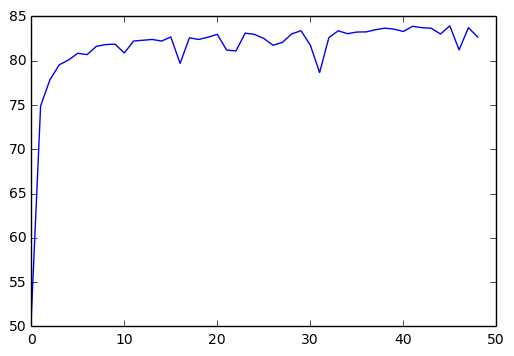

In [ ]:
# top-1 %
plt.plot(scores)

In [18]:
# model.save('out/same-artist-2.h5')